# DeepLearning 03c. Recurrent Neural Nets (RNN)

**NB**: This is a simple demo. Hyperparams are not tuned for optimal performance.

* **Implementation 4f**: RNN with Tensorflow (static Bi-LSTM)
    * Demo the use of TensorBoard 
    
* **Implementation 4g**: RNN with Tensorflow (dynamic Bi-LSTM)
    * Investigate out-of-vocab (OOV) stats

In [1]:
import sys, nltk
import numpy as np
import pandas as pd
import tensorflow as tf
from nltk.corpus import brown
from itertools import chain
from spacy.en import English

## I. Implementation 4f

In [73]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

### A. LOAD & PREPROCESS DATA

In [47]:
# LOAD DATA

sents = brown.sents()

# DATA NORMALIZATION (LEMMATIZATION)

# set limit on vocab size (for demo purpose)
vocabulary_size = 10000
# handle unknown token and corresponding label
pad_token = "<PAD>"
pad_label = "PAD"
unknown_token = "<UNK>"
unknown_label = "UNK"
# start/end tokens (cf. Jurafsky & Martin on n-gram language models)
sentence_start_token = "<S>"
sentence_end_token = "</S>"

# load parser
parser = English()
# lemmatize
X, Y = [], []
for sent in sents:
    words = ' '.join(sent) # list of words -> sent as string, for spacy parser.
    parsed_sent = parser(unicode(words))
    lemmas = [token.lemma_ for token in parsed_sent]
    labels = [token.pos_ for token in parsed_sent] # use spacy's tagging as target.
    X.append(lemmas)
    Y.append(labels)

# build word dictionary for lookup
word_freq = nltk.FreqDist(chain(*X))    
vocab = word_freq.most_common(vocabulary_size - 1) # [(w,freq)...]. leave 1 slot for <UNK>.
i2w = [pad_token] + [elem[0] for elem in vocab] + [unknown_token]
w2i = {w:i for i,w in enumerate(i2w)}
# replace words under frequency cut to <UNK>
for i,sent in enumerate(X):
    X[i] = [w if w in w2i else unknown_token for w in sent]
    
# build label dictionary for lookup
label_vocab = list(set(chain(*Y)))
i2l = [pad_label] + [x for x in label_vocab] + [unknown_label]
l2i = dict([(l,i) for i,l in enumerate(i2l)])
label_vocabulary_size = len(l2i)
for i,labels in enumerate(Y):
    Y[i] = [l for l in labels]

# one-hot encoding: word/label -> word/label index
train_valid_split = (int)(len(X)*0.8)
valid_test_split = (int)(len(X)*0.9)
X_encoded = np.asarray([[w2i[w] for w in sent] for sent in X])
Y_encoded = np.asarray([[l2i[unknown_label] if X[i][j]==unknown_token else l2i[l]
                       for j,l in enumerate(labels)] for i,labels in enumerate(Y)])
X_train = X_encoded[:train_valid_split]
Y_train = Y_encoded[:train_valid_split]
X_valid = X_encoded[train_valid_split:valid_test_split]
Y_valid = Y_encoded[train_valid_split:valid_test_split]
X_test = X_encoded[valid_test_split:]
Y_test = Y_encoded[valid_test_split:]

# PANDA DATAFRAME (sequence lenth for later: dynamic rnn)

df_train = pd.DataFrame({'X':X_train, 'Y':Y_train})
df_train['seq_len'] = map(lambda x:len(x), df_train['X'])
df_valid = pd.DataFrame({'X':X_valid, 'Y':Y_valid})
df_valid['seq_len'] = map(lambda x:len(x), df_valid['X'])
df_test = pd.DataFrame({'X':X_test, 'Y':Y_test})
df_test['seq_len'] = map(lambda x:len(x), df_test['X'])

# GENERIC DATA ITERATOR

class DataIterator():
    
    def __init__(self, df):
        self.df = df
        self.size = len(self.df)
        self.epochs = 0
        self.shuffle()
    
    def shuffle(self):
        # sample 100% with different index, but not add new index column
        self.df = self.df.sample(frac=1).reset_index(drop=True) 
        self.cursor = 0
    
    def next_batch(self, n):
        if self.cursor+n-1 > self.size:
            self.epochs += 1
            self.shuffle()
        res = self.df.ix[self.cursor:self.cursor+n-1]
        self.cursor += n
        return res['X'], res['Y'], res['seq_len']
    
# PADDED ITERATOR

max_len = max(max(df_train['seq_len']), max(df_valid['seq_len']), max(df_test['seq_len'])) # longest sent in corpus.

class FullPaddedDataIterator(DataIterator):
    
    def next_batch(self, n):
        
        if self.cursor+n > self.size:
            self.epochs += 1
            self.shuffle()
        res = self.df.ix[self.cursor:self.cursor+n-1]
        self.cursor += n
        
        maxlen = max_len 
        x = np.zeros([n, maxlen], dtype=np.int32) # empty container.
        y = np.zeros([n, maxlen], dtype=np.int32)
        for i, (x_i,y_i) in enumerate(zip(x,y)):
            x_i[:res['seq_len'].values[i]] = res['X'].values[i] # only fill where there are sequence values.
            y_i[:res['seq_len'].values[i]] = res['Y'].values[i]
        
        return x, y, res['seq_len']

### B. MODEL (BI-LSTM)

In [59]:
# HOUSE CLEANING

def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()
# Clean existing graph before start.
reset_graph()

# CONFIGS

num_epochs = 2
state_size = 100 # i.e. dimension of hidden layer.
num_classes = label_vocabulary_size
batch_size = 100

# DEFINE GRAPH

# Inputs
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, max_len])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, max_len])

# LSTM states
#   cell state: memory cell.
#   hidden state: just the same hidden layer as in simple RNN.
#   fwd & bwd need to both take the same init.
cell_state = tf.placeholder(tf.float32, [batch_size, state_size])
hidden_state = tf.placeholder(tf.float32, [batch_size, state_size])
init_state = tf.nn.rnn_cell.LSTMStateTuple(cell_state, hidden_state) 
    # NB: init_state per se is not the tensor to be trained
    #     it is cell_state & hidden_state!

# Unpack data to slices (shape=(batch_size,1), 1 for one-hot size) across batch members
#   cf. tf.unpack?
inputs_series = tf.split(1, max_len, batchX_placeholder)
labels_series = tf.unpack(batchY_placeholder, axis=1)
# Build Bi-LSTM pipeline: state-state concatenation
with tf.variable_scope('Bi-LSTM'): # not a must. added for the convenience of tensorboard visualization.
    fwd_cell = tf.nn.rnn_cell.BasicLSTMCell(state_size)
    bwd_cell = tf.nn.rnn_cell.BasicLSTMCell(state_size)
    states_series, fwd_current_state, bwd_current_state = tf.nn.bidirectional_rnn(fwd_cell, bwd_cell, inputs_series, 
                                                                                  initial_state_fw=init_state,
                                                                                  initial_state_bw=init_state)
# Forward pass
# Projection to output space
#   NB: these are same as W2, b2 above. now the to-embedding projection is automatic by Tensorflow.
with tf.variable_scope('Output'):
    W = tf.Variable(np.random.rand(state_size*2, num_classes),dtype=tf.float32) # *2: combined weights for fwd & bwd.
    b = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)
    logits_series = [tf.matmul(state, W) + b for state in states_series] 
    predictions_series = [tf.nn.softmax(logits) for logits in logits_series]
# Evaluation
with tf.variable_scope('Evaluation'):
    correct = [tf.equal(tf.argmax(pred,1), tf.cast(true,tf.int64)) 
               for pred,true in zip(predictions_series, labels_series)]
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    # Loss function
    losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels) 
              for logits, labels in zip(logits_series,labels_series)]
    total_loss = tf.reduce_mean(losses)
# Set training method
train_step = tf.train.AdagradOptimizer(1e-3).minimize(total_loss)

##### TENSORBOARD

In [60]:
# Create a summary for our cost and accuracy
#   NB: rerun the previous block to clear existing summaries
# TensorBoard will save the stats and graph to logs_path, then
#   do tensorboard --logdir=/Users/jacobsw/Desktop/UNIV/SPRING_2017/LIN389C_RSCH_COMPLING/CODE/TENSORBOARD/ --port=6006
#   in terminal to get a local host to TensorBoard's brower interface.
logs_path = '/Users/jacobsw/Desktop/UNIV/SPRING_2017/LIN389C_RSCH_COMPLING/CODE/TENSORBOARD/'
tf.summary.scalar("Loss", total_loss)
tf.summary.scalar("Accuracy", accuracy)
summary_op = tf.summary.merge_all()

In [72]:
%%time

with tf.Session() as sess:
    
    # Initialize graph
    sess.run(tf.global_variables_initializer())
    
    # Add a summary writer to record metrics
    writer = tf.summary.FileWriter(logs_path, graph=sess.graph)
    
    # Create data readers
    tr = FullPaddedDataIterator(df_train)
    
    # Record keepers
    tr_losses, tr_accuracies = [], []  
    global_step = 0 # tracking overall steps, for recording stats.
    step = 0 # tracking within-epoch steps, for notifying validation after defined steps.
    current_epoch = 0
    # Training
    cell_state_ = np.zeros((batch_size, state_size))
    hidden_state_ = np.zeros((batch_size, state_size))
    
    while current_epoch < num_epochs:
        global_step += 1
        step += 1
        tr_x,tr_y,_ = tr.next_batch(batch_size) # _ for sequence length. not used yet.
        train_loss_, train_step_, init_state_, train_accuracy_, train_summary_ = sess.run(
            [total_loss, train_step, init_state, accuracy, summary_op],
             feed_dict = {batchX_placeholder:tr_x,
                          batchY_placeholder:tr_y,
                          cell_state:cell_state_,
                          hidden_state:hidden_state_}
            ) # NB: in decoding bidirectional networks, ALWAYS feed cell_state & hidden_state rather than init_state!
        tr_losses.append(train_loss_)
        tr_accuracies.append(train_accuracy_)
        if step % 100 == 0:
            print "Avg Training Loss at", step, ':', np.mean(tr_losses)
            print "Avg Training Accuracy at", step, ':', np.mean(tr_accuracies)
            va_losses, va_accuracies = [], []
            va = FullPaddedDataIterator(df_valid)
            while va.epochs==0:
                va_x,va_y,_ = va.next_batch(batch_size) # evaluate all.
                valid_loss_, valid_accuracy_, init_state_ = sess.run(
                    [total_loss, accuracy, init_state],
                     feed_dict = {batchX_placeholder:va_x,
                                  batchY_placeholder:va_y,
                                  cell_state:cell_state_,
                                  hidden_state:hidden_state_}
                    )
                va_losses.append(valid_loss_)
                va_accuracies.append(valid_accuracy_)
            # Record validation summary at step
            avg_va_loss_, avg_va_accuracy_ = np.mean(va_losses), np.mean(va_accuracies)
            valid_summary_ = tf.Summary()
            valid_summary_.ParseFromString(train_summary_) # add training stats (always add training stats).
            valid_summary_.value.add(tag='Validation Loss', simple_value=(float)(avg_va_loss_))
            valid_summary_.value.add(tag='Validation Accuracy', simple_value=(float)(avg_va_accuracy_))
            writer.add_summary(valid_summary_, global_step)
            print "Avg Validation Loss:", avg_va_loss_
            print "Avg Validation Accuracy:", avg_va_accuracy_
            print
        else:
            writer.add_summary(train_summary_, global_step)
        if tr.epochs > current_epoch: # go to the next epoch.
            current_epoch += 1
            step = 0
    te = FullPaddedDataIterator(df_test)
    while te.epochs==0:
        te_x,te_y,_ = te.next_batch(batch_size) 
        test_loss_, test_accuracy_, init_state_ = sess.run(
            [total_loss, accuracy, init_state],
             feed_dict = {batchX_placeholder:te_x,
                          batchY_placeholder:te_y,
                          cell_state:cell_state_,
                          hidden_state:hidden_state_}
            )
    print "Final Training Loss:", np.mean(tr_losses)
    print "Final Training Accuracy:", np.mean(tr_accuracies)   
    print "Final Test Loss:", np.mean(test_loss_)
    print "Final Test Accuracy:", np.mean(test_accuracy_)

Avg Training Loss at 100 : 1.19932
Avg Training Accuracy at 100 : 0.866535
Avg Validation Loss: 0.522752
Avg Validation Accuracy: 0.925937

Avg Training Loss at 200 : 0.859387
Avg Training Accuracy at 200 : 0.883769
Avg Validation Loss: 0.352614
Avg Validation Accuracy: 0.929384

Avg Training Loss at 300 : 0.710504
Avg Training Accuracy at 300 : 0.890864
Avg Validation Loss: 0.29721
Avg Validation Accuracy: 0.929576

Avg Training Loss at 400 : 0.626282
Avg Training Accuracy at 400 : 0.894346
Avg Validation Loss: 0.269763
Avg Validation Accuracy: 0.930841

Avg Training Loss at 100 : 0.544777
Avg Training Accuracy at 100 : 0.898244
Avg Validation Loss: 0.243618
Avg Validation Accuracy: 0.932508

Avg Training Loss at 200 : 0.510426
Avg Training Accuracy at 200 : 0.900081
Avg Validation Loss: 0.231697
Avg Validation Accuracy: 0.933298

Avg Training Loss at 300 : 0.483169
Avg Training Accuracy at 300 : 0.901641
Avg Validation Loss: 0.222073
Avg Validation Accuracy: 0.933826

Avg Training Lo

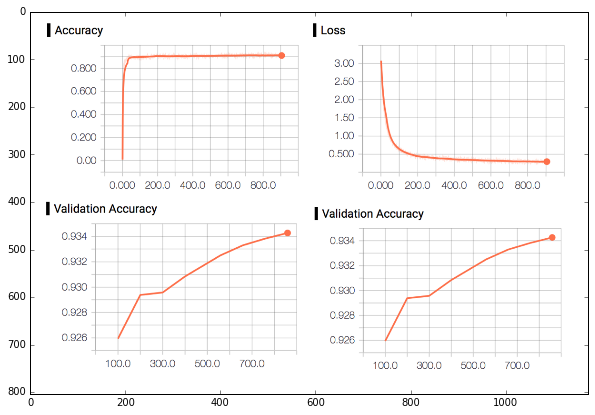

In [74]:
# That which show up in TensorBoard "Scalars"
#   NB: 4 images are stitched together by me. They are individual interactive graphs in browser.
graph = mpimg.imread(logs_path+"tensorboard_graph.png")
plt.figure(figsize=(10,20))
plt.imshow(graph) # ignore the border ticks, these are counting pixels.
plt.show()

## II. Implementation 4g

In [ ]:
# HOUSE CLEANING

def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()
# Clean existing graph before start.
reset_graph()

# CONFIGS

num_epochs = 2
state_size = 100 # i.e. dimension of hidden layer.
num_classes = label_vocabulary_size
batch_size = 100

# DEFINE GRAPH

# Inputs
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, max_len])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, max_len])
batchSeqlen_placeholder = tf.placeholder(tf.int32, [batch_size])

# LSTM states
#   cell state: memory cell.
#   hidden state: just the same hidden layer as in simple RNN.
#   fwd & bwd need to both take the same init.
cell_state = tf.placeholder(tf.float32, [batch_size, state_size])
hidden_state = tf.placeholder(tf.float32, [batch_size, state_size])
init_state = tf.nn.rnn_cell.LSTMStateTuple(cell_state, hidden_state)

# Projection to output space
#   NB: these are same as W2, b2 above. now the to-embedding projection is automatic by Tensorflow.
W = tf.Variable(np.random.rand(state_size*2, num_classes),dtype=tf.float32)
b = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

# Unpack data to slices (shape=(batch_size,1), 1 for one-hot size) across batch members
#   cf. tf.unpack?
# Build Bi-LSTM pipeline: state-state concatenation
fwd_cell = tf.nn.rnn_cell.BasicLSTMCell(state_size)
bwd_cell = tf.nn.rnn_cell.BasicLSTMCell(state_size)
# Dynamic RNN architecture
#   tf.expand_dims(batchX_placeholder, -1): dynamic_rnn takes input with [batch_size, max_len, input_size],
#                                           we thus add 1 extra dimension [input_size].
states_series_tuple, current_states_tuple = tf.nn.bidirectional_dynamic_rnn(fwd_cell, bwd_cell, 
                                                                            tf.expand_dims(batchX_placeholder, -1),
                                                                            sequence_length=batchSeqlen_placeholder,
                                                                            initial_state_fw=init_state,
                                                                            initial_state_bw=init_state)
fwd_states_series, bwd_states_series = states_series_tuple
fwd_states_series = tf.reshape(fwd_states_series, [-1, state_size]) # shape: [batch_size*max_len, state_size].
bwd_states_series = tf.reshape(bwd_states_series, [-1, state_size])
states_series = tf.concat(1, [fwd_states_series, bwd_states_series]) # concat along the dim of state_size.

# Forward pass 
logits = tf.matmul(states_series, W) + b
labels = tf.reshape(batchY_placeholder, [-1]) # make labels into one long list.
logits_series = tf.unpack(tf.reshape(logits, [batch_size, max_len, num_classes]), axis=1)
predictions_series = [tf.nn.softmax(logit) for logit in logits_series]
# Evaluation
preds_list = [tf.argmax(pred,1) for pred in predictions_series]
preds_concat = tf.concat(0, preds_list) # concatenate batch predictions into one list to match the format of labels.
correct = tf.equal(preds_concat, tf.cast(labels,tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
# Loss function
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels)
total_loss = tf.reduce_mean(losses)
# Set training method
train_step = tf.train.AdagradOptimizer(1e-4).minimize(total_loss)

In [ ]:
%%time

with tf.Session() as sess:
    # Initialize graph
    sess.run(tf.global_variables_initializer())
    # Create data readers
    tr = FullPaddedDataIterator(df_train)
    te = FullPaddedDataIterator(df_test)
    # Record keepers
    tr_losses, te_losses = [], []
    tr_accuracies, te_accuracies = [], []    
    step = 0
    current_epoch = 0
    # Training
    cell_state_ = np.zeros((batch_size, state_size))
    hidden_state_ = np.zeros((batch_size, state_size))
    
    while current_epoch < num_epochs:
        step += 1
        tr_x,tr_y,_ = tr.next_batch(batch_size) # _ for sequence length. not used yet.
        total_loss_, train_step_, init_state_, accuracy_ = sess.run(
            [total_loss, train_step, init_state, accuracy],
            feed_dict = {batchX_placeholder:tr_x,
                         batchY_placeholder:tr_y,
                         batchSeqlen_placeholder:te_seqlen,
                         cell_state:cell_state_,
                         hidden_state:hidden_state_}
            )
        tr_losses.append(total_loss_)
        tr_accuracies.append(accuracy_)
        if step % 100 == 0:
            print "Avg Training Loss at", step, ':', np.mean(tr_losses)
            print "Avg Training Accuracy at", step, ':', np.mean(tr_accuracies)
            te_x,te_y,_ = te.next_batch(batch_size) # randomly sample 100 to evaluate.
            total_loss_, train_step_, init_state_, accuracy_ = sess.run(
                [total_loss, train_step, init_state, accuracy],
                feed_dict = {batchX_placeholder:te_x,
                             batchY_placeholder:te_y,
                             batchSeqlen_placeholder:te_seqlen,
                             cell_state:cell_state_,
                             hidden_state:hidden_state_}
                )
            te_losses.append(total_loss_)
            te_accuracies.append(accuracy_)
            print "Avg Test Loss at", step, ':', np.mean(te_losses)
            print "Avg Test Accuracy at", step, ':', np.mean(te_accuracies)
            print
        if tr.epochs > current_epoch: # go to the next epoch.
            current_epoch += 1
            step = 0
    print "Final Avg Training Loss:", np.mean(tr_losses)
    print "Final Avg Training Accuracy:", np.mean(tr_accuracies)   
    print "Final Avg Test Loss:", np.mean(te_losses)
    print "Final Avg Test Accuracy:", np.mean(te_accuracies)